## Problema 1

Para empezar, cargamos el dataset que está en el archivo __"auto.csv"__

In [1]:
import pandas as pd

auto=pd.read_csv('auto.csv')
auto.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
0,8,307.0,130.0,3504.0,12.0,70,1,18.0
1,8,350.0,165.0,3693.0,11.5,70,1,15.0
2,8,318.0,150.0,3436.0,11.0,70,1,18.0
3,8,304.0,150.0,3433.0,12.0,70,1,16.0
4,8,302.0,140.0,3449.0,10.5,70,1,17.0


En primer lugar, crearemos __variables dummies__ que contengan la información existente en las columnas __cylinders__ y __origin__. Representaremos de forma numérica dichas variables categóricas para obtener un modelo de predicción más correcto, ya que le estamos dando la misma importancia a las distintas categorías que definen las variables categóricas (por ejemplo, existirán los columnas __cyl_8__ para los coches de 8 cilindros, y __cyl_4__ para los coches de 4 cilindros).

Para ello, se definen con la siguiente sección de código las variables dummies creadas y, a su vez, se eliminan del dataframe las variables categóricas para evitar información redundante en los datos. 

La variable a predecir, __mpg__, la hemos situado en la última columna de nuestro dataframe para diferenciarla del resto de variables independientes.

In [2]:
ciclos_dummies=pd.get_dummies(auto.cylinders).add_prefix('cyl_')
origenes_dummies=pd.get_dummies(auto.origin).add_prefix('orig_')
del auto['cylinders']
del auto['origin']

auto=pd.concat([auto,ciclos_dummies,origenes_dummies], axis=1, join='inner')
auto['mpg']=auto.pop('mpg')
auto.head()

,displacement,horsepower,weight,acceleration,model_year,cyl_3,cyl_4,cyl_5,cyl_6,cyl_8,orig_1,orig_2,orig_3,mpg
0,307.0,130.0,3504.0,12.0,70,0,0,0,0,1,1,0,0,18.0
1,350.0,165.0,3693.0,11.5,70,0,0,0,0,1,1,0,0,15.0
2,318.0,150.0,3436.0,11.0,70,0,0,0,0,1,1,0,0,18.0
3,304.0,150.0,3433.0,12.0,70,0,0,0,0,1,1,0,0,16.0
4,302.0,140.0,3449.0,10.5,70,0,0,0,0,1,1,0,0,17.0


De esta manera, hemos obtenido las subcategorías deseadas. Aunque el dataframe almacene más información, la representación es más correcta ahora.

A continuación, mostraremos gráficamente la variable objetivo (__mpg__) con respecto al resto de variables del dataset, para hacer una primera inspección de las posibles dependencias entre dicha variable del resto de posibles predictores:

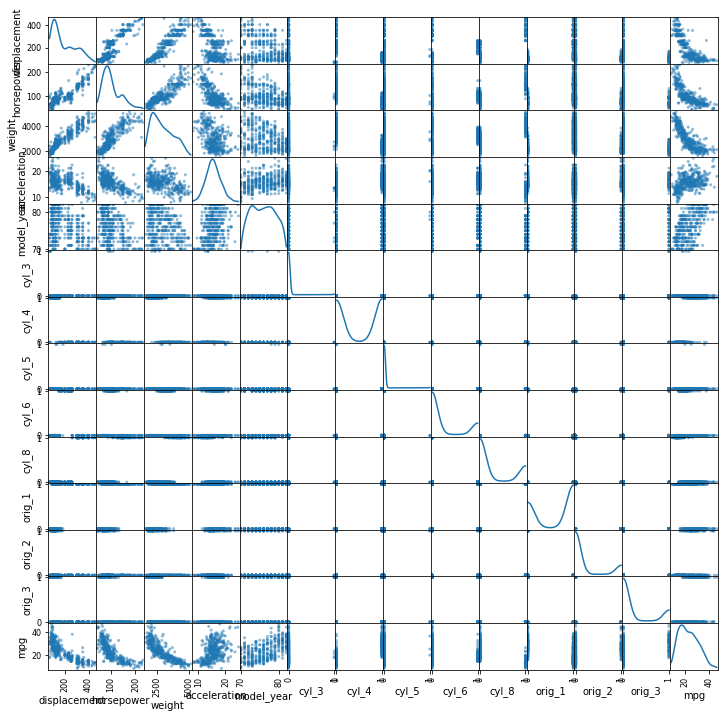

In [4]:
from pandas.plotting import scatter_matrix

scatter_matrix(auto,figsize=(12,12),diagonal='kde');

Separando la __variable objetivo__ del resto de __variables independientes__ del problema:

In [5]:
objetivo = auto.pop('mpg')  # Guardo en 'objetivo' la variable a predecir

v_disc=[ x for x in auto.columns if '_' in x and x!='model_year']      # Variables dummies
v_cont=[ x for x in auto.columns if '_' not in x or x=='model_year']   # Variables continuas

continuas=auto[v_cont]   # Creo dos dataframes para las variables independientes
discretas=auto[v_disc]

del continuas['model_year'] # Descartamos "model year" de las variables independientes continuas,
                               # ya que no es adecuado para realizar predicciones.


### Normalización

Normalizamos todas las variables continuas, ante falta de unidades que las definan:

In [6]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

continuas_norm=pd.DataFrame()

# Variables continuas independientes
for c in continuas:
    data = np.array(list(continuas[c])).reshape(-1, 1)
    scaler = MinMaxScaler().fit(data)
    continuas_norm[c] =scaler.transform(data).reshape(len(data))

#Variable dependiente (mpg)
data = np.array(list(objetivo)).reshape(-1, 1)
scaler = MinMaxScaler().fit(data)
objetivo_norm =scaler.transform(data).reshape(len(data))

continuas_norm.head()

,displacement,horsepower,weight,acceleration
0,0.617571,0.456522,0.536150,0.238095
1,0.728682,0.646739,0.589736,0.208333
2,0.645995,0.565217,0.516870,0.178571
3,0.609819,0.565217,0.516019,0.238095
4,0.604651,0.510870,0.520556,0.148810


### Selección univariante de características

Empleamos el método de la varianza para descartar la __aceleración__ de nuestras variables continuas, ya que no satisface un valor mínimo de varianza para incorporarlo al modelo:

In [7]:
from sklearn.feature_selection import VarianceThreshold

var_th = VarianceThreshold(0.04)
x_var = var_th.fit_transform(continuas_norm)

print("Variables continuas originales ", continuas_norm.shape[1])
print("Variables continuas finales ", x_var.shape[1])

print("Listado de variables continuas", np.asarray(list(continuas_norm))[var_th.get_support()])

Variables continuas originales  4
Variables continuas finales  3
Listado de variables continuas ['displacement' 'horsepower' 'weight']


Actualizamos el dataframe __continuas_norm__ sin considerar ya la columna descartada:

In [8]:
continuas_norm=continuas_norm[np.asarray(list(continuas_norm))[var_th.get_support()]]
continuas_norm.head()

,displacement,horsepower,weight
0,0.617571,0.456522,0.536150
1,0.728682,0.646739,0.589736
2,0.645995,0.565217,0.516870
3,0.609819,0.565217,0.516019
4,0.604651,0.510870,0.520556


### VIF (Multicolinealidad)

A continuación, barajaremos si algunas de las variables independientes del dataframe está expresada linealmente en función de alguna otra (teniendo, de esta manera, variables que no aporten en el modelo que diseñaremos). Para ello, nos servimos del __criterio del VIF__:

In [9]:
from sklearn.linear_model import LinearRegression

def calculateVIF(data):
    features = list(data.columns)
    num_features = len(features)
    
    model = LinearRegression()
    
    result = pd.DataFrame(index = ['VIF'], columns = features)
    result = result.fillna(0)
    
    for ite in range(num_features):
        x_features = features[:]
        y_featue = features[ite]
        x_features.remove(y_featue)
        
        x = data[x_features]
        y = data[y_featue]
        
        model.fit(data[x_features], data[y_featue])
        
        result[y_featue] = 1/(1 - model.score(data[x_features], data[y_featue]))
    
    return result

In [10]:
def selectDataUsingVIF(data, max_VIF = 8):
    result = data.copy(deep = True)
    
    VIF = calculateVIF(result)
    
    while VIF.as_matrix().max() > max_VIF:
        col_max = np.where(VIF == VIF.as_matrix().max())[1][0]
        features = list(result.columns)
        features.remove(features[col_max])
        result = result[features]
        
        VIF = calculateVIF(result)
        
    return result

In [11]:
calculateVIF(selectDataUsingVIF(pd.concat([continuas_norm,discretas], axis=1, join='inner')))

C:\Users\jecar\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\jecar\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\jecar\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\jecar\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\jecar\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\jecar\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\jecar\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\jecar\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divid

,horsepower,weight,cyl_4,cyl_5,cyl_6,orig_2,orig_3
VIF,5.219348,6.779758,7.24123,1.19817,2.783917,1.508133,1.599381


Por el criterio del __VIF__, comprobamos que tanto el peso como la potencia estaban relacionados con la cilindrada del vehículo, por lo que __eliminamos la cilindrada (displacement)__ de las características continuas, ya que añade información redundante al modelo.

Con respecto a las __variables dummies__, podemos apreciar que se han eliminado tanto __orig_1__ como __cyl_3__, ya que estas se pueden expresar como combinación lineal del resto de variables dummies.

Así, nos quedarían los siguientes predictores:

In [12]:
continuas_norm.pop('displacement')
discretas.pop('cyl_3')
discretas.pop('orig_1')

continuas_norm.head()

,horsepower,weight
0,0.456522,0.536150
1,0.646739,0.589736
2,0.565217,0.516870
3,0.565217,0.516019
4,0.510870,0.520556


In [14]:
discretas.head()

,cyl_4,cyl_5,cyl_6,cyl_8,orig_2,orig_3
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0


### Regresión LASSO

Podemos obtener un modelo mediante __regresión Lasso__, para penalizar mediante el coeficiente de regularización aquellas variables del modelo que no aporten demasiado al mismo. Seleccionamos inicialmente un valor de __"alpha"__ aleatorio.

In [15]:
from sklearn.linear_model import Lasso


model_lasso1 = Lasso(alpha = 0.1)
model_lasso1.fit(pd.concat([continuas_norm,discretas], axis=1, join='inner'), objetivo)

print(model_lasso1.coef_)

[ -7.61728919 -10.03681859   4.78240466   0.          -0.
  -0.           0.           1.98768175]


Vemos que el valor de __alpha__ considerado penaliza en exceso algunas de las categorías del vehículo. Recurriremos a técnicas de validación cruzada para obtener el parámetro __alpha__ que aporte mejores resultados, teniendo en cuenta el sobreajuste.

### Validación

Usando la validación cruzada, busco el valor de __"alfa"__ que mejor defina el modelo de regresión Lasso:

In [16]:
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

# Creación del modelo
model = Lasso()

param_grid = dict(alpha = sp_rand())

rsearch = RandomizedSearchCV(estimator = model,
                             param_distributions = param_grid,
                             n_iter = 100,
                             cv = 10,
                             random_state = 1)
rsearch.fit(pd.concat([continuas_norm,discretas], axis=1, join='inner'), objetivo)

# Los mejores parametros para el modelo
print('El mejor parametro es', rsearch.best_params_)
print('El mejor score es', rsearch.best_score_)

El mejor parametro es {'alpha': 0.00011437481734488664}
El mejor score es 0.4816175431712319


C:\Users\jecar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Apreciamos que el valor óptimo de __"alpha"__ (haciendo uso de la __validación cruzada__) está bastante próximo a cero, por lo que apenas se penalizan las características a las que hemos recurrido para sintetizar el modelo.

Con dicho valor de alfa, los coeficientes obtenidos por Lasso son:

In [17]:
from sklearn.linear_model import Lasso

model_lasso = Lasso(alpha = 0.00011437481734488664)
model_lasso.fit(pd.concat([continuas_norm,discretas], axis=1, join='inner'), objetivo)

print(model_lasso.coef_)

[-12.01082501 -13.90371709   8.59747319  10.99609575   4.99687667
   7.46653552  -0.08635818   2.47900929]


Con este valor de __alpha__, vemos que no se penaliza ninguna de las características de las que nos hemos servido para construir el modelo. En mayor o menor medida (segun el orden de cada uno de los coeficientes), cada uno de los predictores seleccionados hasta ahora aporta información al modelo de predicción.

A continuación, se muestra la predicción hecha por el __modelo Lasso__ del consumo del vehículo en función de, tan solo, 8 variables independientes (de las 13 iniciales entre las que se incluían todas las variables dummies):

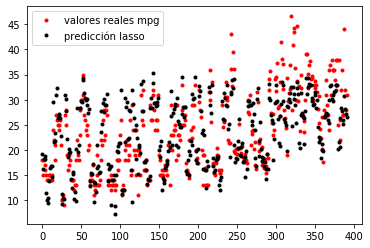

In [18]:
import matplotlib.pyplot as plt

plt.plot(objetivo,'.r', label='valores reales mpg')
plt.plot(model_lasso.predict(pd.concat([continuas_norm,discretas], axis=1, join='inner')),'.k', label='predicción lasso')
plt.legend()

Comprobamos que con la predicción realizada por lasso, para las características empleadas en el modelo, obtenemos valores bastante próximos a los del consumo (__"mpg"__) que se querían estimar desde el principio del problema. 

## Problema 2

Obtenemos los datos que se nos proporcionan en el enunciado:

In [28]:
import theano
import theano.tensor as T
import numpy as np
import math
import matplotlib.pyplot as plt

trX = np.linspace(-1,1,101)
trY = np.linspace(-1,1,101)

for i in range(len(trY)):
    trY[i]=math.log(1+0.5*abs(trX[i]))+trX[i]/3+np.random.randn()*0.033

Representándolos gráficamente, vemos que tienen esta forma:

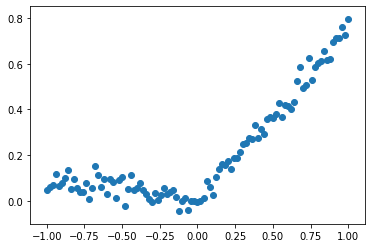

In [29]:
plt.scatter(trX,trY)

Atendiendo al valor que toman los datos definidos en el eje de ordenadas (trY), vemos que tendremos que buscar un modelo modelado de la siguiente forma: 

\begin{align}
y=log(1+w_{0} · \left| x \right| )+(x · w_{1})
\end{align}

despreciando el ruido que se añade como término independiente en los datos.

Trataremos de obtener los parámetros __w_0__ y __w_1__ que definan dicho modelo, para que se ajuste a los datos proporcionados. 
__La definición de los parámetros__, que se actualizan en cada iteración con el fin de ir minimizando el coste asociado al modelo, es la siguiente:

\begin{align}
w_{i}=w_{i}- \alpha \frac{\partial}{\partial w_{i}} J(w_{0},w_{1}) 
\end{align}

Como __función de coste__, tomaremos el error cuadrático medio. A continuación se define el modelo con theano, así como la función de entrenamiento del modelo y los resultados para 15 iteraciones con los datos proporcionados al comienzo del ejercicio.

In [30]:

X = T.scalar()
Y = T.scalar()

def model(X, w_0, w_1):
    return np.log(1+w_0*abs(X))+(X*w_1)

alpha=0.01   # factor de aprendizaje
w_0 = theano.shared(np.asarray(0., dtype = theano.config.floatX))
w_1 = theano.shared(np.asarray(0., dtype = theano.config.floatX))
y = model(X, w_0, w_1)

cost     = T.mean(T.sqr(y - Y))
gradient_w_0 = T.grad(cost = cost, wrt = w_0)
gradient_w_1 = T.grad(cost = cost, wrt = w_1)
updates  = [[w_0, w_0 - gradient_w_0 * alpha], [w_1, w_1 - gradient_w_1 * alpha]]

train = theano.function(inputs = [X, Y], outputs = cost, updates = updates)

for i in range(15):
    for x, y in zip(trX, trY):
        cost_i = train(x, y)
    print('En el paso', i, 'el valor de w_0 es', w_0.get_value(),
           'y w_1 es', w_1.get_value(), 'con un coste', cost_i)
    

En el paso 0 el valor de w_0 es 0.2014198791926212 y w_1 es 0.16800257477769517 con un coste 0.2100797450635326
En el paso 1 el valor de w_0 es 0.3075687403268276 y w_1 es 0.2535960430946437 con un coste 0.07921077925518034
En el paso 2 el valor de w_0 es 0.37203302345511813 y w_1 es 0.29550470392707545 con un coste 0.03543606905379854
En el paso 3 el valor de w_0 es 0.41353428182598084 y w_1 es 0.31552030029310674 con un coste 0.018704876579509182
En el paso 4 el valor de w_0 es 0.44104172949325127 y w_1 es 0.324804483133951 con un coste 0.011509394130613231
En el paso 5 el valor de w_0 es 0.4595685349442965 y w_1 es 0.32892608083867314 con un coste 0.008072423371969896
En el paso 6 el valor de w_0 es 0.4721641458188187 y w_1 es 0.33062105297240607 con un coste 0.00627806079004231
En el paso 7 el valor de w_0 es 0.48077628592038807 y w_1 es 0.3312137946729409 con un coste 0.005271763636140376
En el paso 8 el valor de w_0 es 0.48668572691085393 y w_1 es 0.3313335077212687 con un coste 

Vemos cómo el coste asociado al modelo disminuye iteración tras iteración. Viendo el resultado final obtenido para los parámetros __w_0__ y __w_1__, observamos cómo el modelo de regresión es capaz de ajustar con bastante exactitud los datos iniciales:


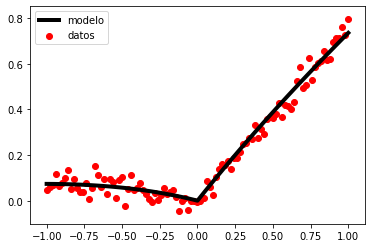

In [31]:
w__0=float(w_0.get_value())
w__1=float(w_1.get_value())

plt.scatter(trX,trY, c='r',label='datos')
plt.plot(trX,np.log(1+w__0*abs(trX))+(trX*w__1), linewidth=4, c='k', label='modelo')
plt.legend()

## Problema 3

Para empezar, cargamos el dataset que está en el archivo __"crime_data.csv"__

In [32]:
import pandas as pd

crime_data=pd.read_csv('crime_data.csv')
crime_data.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


Tomaremos como características para llevar a cabo el clústering los tipos de crímenes y el porcentaje de población urbana, y los almacenaremos en el dataframe __x__. Por otro lado, almacenaremos el estado (__State__) en __y__:

In [33]:
y=crime_data.pop('State')

x=crime_data

Estandarizamos las características con el fin de obtener el mejor resultado posible a la hora de etiquetar los datos:

In [34]:
from sklearn.preprocessing import StandardScaler

x = StandardScaler().fit_transform(x)

Mediante __PCA__, buscamos los dos componentes principales que aseguran la mayor diferenciación de los datos.

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

        
#print(x_pca)

print("Varianza explicada con la primera componente:", pca.explained_variance_ratio_[0])
print("Varianza explicada con la segunda componente:", pca.explained_variance_ratio_[1])


Varianza explicada con la primera componente: 0.6200603947873736
Varianza explicada con la segunda componente: 0.2474412881349602


Las dos primeras componentes representan, aproximadamente, el 86% de la varianza de los datos. 

Representemos los datos considerando dichas componentes para ver la forma que tienen:

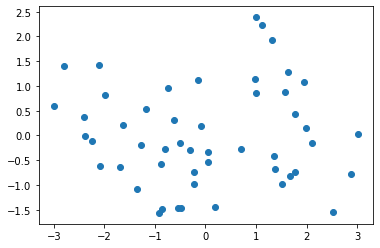

In [36]:
import matplotlib.pyplot as plt

plt.scatter(x_pca[:,0],x_pca[:,1])

Puede observarse que en el __eje X (primera componente)__ los datos se encuentran ligeremente más separados que en el __eje Y (segunda componente)__. Esto es lógico, ya que la primera componente principal explica el 62% de la varianza de los datos, mientras que la segunda componente representa el 24%. 

Recurrimos a la función que nos da información de la __distorsión__ que existe en función del número de clústeres, así como el valor de __sillhouette__, que también nos servirá como indicador.

Las próximas gráficas están referidas a las componentes principales que hemos obtenido anteriormente del dataset.

In [37]:
from sklearn.cluster import KMeans

def plot_dispersion(x, figure_name, max_k = 10, n_init = 10):
    inertia = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters = k, n_init = n_init).fit(x)
        inertia.append(kmeans.inertia_)

    plt.plot(range(1, max_k), inertia, 'bx-')
    plt.xlabel('k')
    plt.ylabel(u'Distorsión')
    plt.title(figure_name)

In [38]:
from sklearn.metrics import silhouette_score

def plot_sillhouette(blobs, figure_name, max_k = 10, n_init = 10):
    sillhouette_avgs = []
    
    for k in range(2, max_k):
        kmean = KMeans(n_clusters = k, n_init = n_init).fit(blobs)
        sillhouette_avgs.append(silhouette_score(blobs, kmean.labels_))
        
    plt.plot(range(2, max_k), sillhouette_avgs)
    plt.title(figure_name)

Observamos gráficamente el valor de __sillhouette__, que sirve como medida de la adecuación de los datos con su propio clúster. Considera, al mismo tiempo, tanto la distancia inter como intra-clúster para que se diferencien entre sí los datos de diferentes grupos. Nos interesa un valor alto de este score.

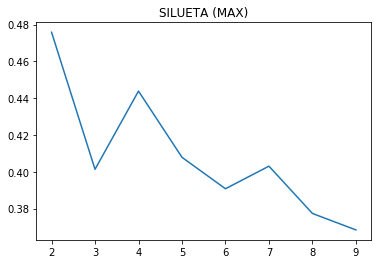

In [39]:
plot_sillhouette(x_pca[:,0:2], 'SILUETA (MAX)')

Observamos gráficamente el valor de la __distorsión__. Nos interesa que la dispersión sea la menor posible, porque de esta manera la distancia media entre los datos y el centroide de su propio cúster es la menor posible:

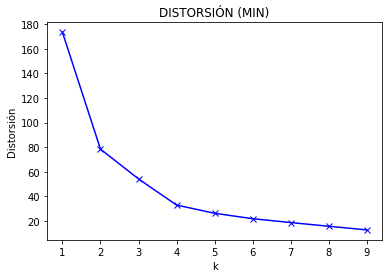

In [40]:
plot_dispersion(x_pca[:,0:2], 'DISTORSIÓN (MIN)')

Vemos que se producen __codos en la gráfica de distorsión tanto para 2 como para 4 clústers__. Y con respecto a la gráfica de sillhouette, vemos que el máximo se da para 2 clústers. Sin embargo, para sólo 2 clusters, se observa una dispersión intra-cluster relativamente alta, observando la siguiente representación con k=2:

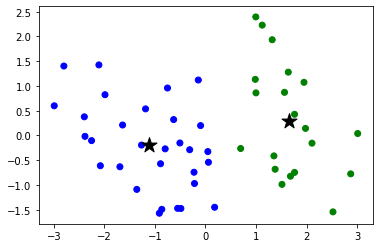

In [41]:
color_map = np.array(['b','g','r','c','m','y','k'])

kmeans = KMeans(n_clusters = 2, random_state = 1).fit(x_pca[:,0:2])
classes_2 = kmeans.predict(x_pca[:,0:2])
centroides_2=kmeans.cluster_centers_

plt.scatter(x_pca[:, 0], x_pca[:, 1],color = color_map[classes_2])
plt.scatter(centroides_2[:, 0], centroides_2[:, 1], marker = '*', s = 250, color = 'black')

Tomando un valor de k=4, la dispersión media de cada clúster disminuye, aunque bien es cierto que los clústers no se encuentran tan diferenciados entre ellos como en la solución representada anteriormente.

Representemos los datos recurriendo a __K-Means__, empleando un número de clusters igual a 4. También se representan los centroides que se corresponden con cada uno de los clústers.

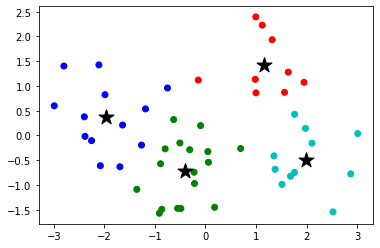

In [42]:
color_map = np.array(['b','g','r','c','m','y','k'])

kmeans = KMeans(n_clusters = 4, random_state = 1).fit(x_pca[:,0:2])
classes_4 = kmeans.predict(x_pca[:,0:2])
centroides_4=kmeans.cluster_centers_

plt.scatter(x_pca[:, 0], x_pca[:, 1],color = color_map[classes_4])
plt.scatter(centroides_4[:, 0], centroides_4[:, 1], marker = '*', s = 250, color = 'black')

Comparando ambos resultados, __se decide separar el conjunto de datos en 2 clusters en lugar de en 4__, ya que el score del sillhouette pondera de manera significativa la separación intra e inter-clúster. Además, aunque bien es cierto que la dispersión intra-clúster mejora considerablemente hasta llegar a k=4 (segundo codo de la gráfica de la distorsión), los distintos grupos no se encuentran tan diferenciados entre ellos, ya que la distancia inter-cluster no es demasiado significativa (se obtiene el segundo máximo del silhouette para k=4, pero el resultado global no es tan bueno)

Definiremos el diccionario __"cities"__ en el que la __clave__ se corresponde con un identificador numérico para el __color que identifica el cluster (0-->azul, 1-->verde)__. El __valor__ se corresponde con una lista en la que se almacenan las ciudades que se correspondan con cada dato etiquetado. 

In [43]:
cities={'0':[],'1':[]}
for indice_f,fila in crime_data.iterrows():
        cities[str(classes_2[indice_f])].append(y[indice_f])

A continuación, como se pedía en el enunciado del problema, se muestran las ciudades etiquetadas en cada uno de los clústers obtenidos, así como los centroides de cada clúster.

In [44]:
cities['0'] # Ciudades del primer clúster (en AZUL)

['Arkansas',
 'Connecticut',
 'Delaware',
 'Hawaii',
 'Idaho',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Maine',
 'Massachusetts',
 'Minnesota',
 'Montana',
 'Nebraska',
 'New Hampshire',
 'New Jersey',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Dakota',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming']

In [45]:
cities['1'] # Ciudades del segundo clúster (en VERDE)

['Alabama',
 'Alaska',
 'Arizona',
 'California',
 'Colorado',
 'Florida',
 'Georgia',
 'Illinois',
 'Louisiana',
 'Maryland',
 'Michigan',
 'Mississippi',
 'Missouri',
 'Nevada',
 'New Mexico',
 'New York',
 'North Carolina',
 'South Carolina',
 'Tennessee',
 'Texas']

In [46]:
centroides_2 # Centroides de los dos clústers

array([[-1.10781782, -0.19978289],
       [ 1.66172672,  0.29967433]])